# Latent Space Models

Let's start with a much simpler version of the model.

### Notation:

- $V$:  number of vertices
- $D$:  latent space dimensionality
- $A \in \{0, 1\}^{V \times V}$:  binary adjacency matrix
- $b$: connection probability bias
- $X \in \mathbb{R}^{V \times D}$: latent embedding

### Probabilistic model:

- $x_v \sim \mathcal{N}(0, I_D)$
- $b \sim \mathcal{N}(0, 1)$ 
- $A_{u,v} \sim \text{Bern}\left(\sigma(b + x_u^{\mathsf{T}} x_v ) \right); \quad u < v$
- $A_{v,v} \triangleq 0$ 
- $A_{v,u} \triangleq A_{u,v}$
- where $\sigma(x) = (1+ e^{-x})^{-1}$


### Multi-network extension

- $Z \in \mathbb{R}^{V \times V}$: per-connection bias


In [80]:
import numpy as np
import numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import pypolyagamma as ppg
from pypolyagamma import BinomialRegression

from pybasicbayes.util.text import progprint_xrange

In [75]:
class LatentSpaceModel(object):
    def __init__(self, V, D, X=None, b=None):
        self.V, self.D = V, D
        
        # Initialize parameters
        self.X = npr.randn(V, D) if X is None else X
        self.b = npr.randn() if b is None else b
        
        # Models encapsulate data
        self.As = []

    def add_data(self, A):
        assert A.shape == (self.V, self.V)
        assert A.dtype == bool
        assert A.min() >= 0 and A.max() <= 1
        self.As.append(A)
        
    def resample(self):
        self._resample_X()
    
    def _resample_X(self):
        # resample rows one at a time given the remainder
        #
        #     p(x_v | A, {x_u}_{u \neq v}, b)
        #
        # Since the matrix is symmetric, we only need the v-th column
        # 
        # \propto \prod_{u != v} p(A_{u,v} | x_u, x_v, b)  p(x_v | 0, I)
        # \propto \prod_{u != v} Bern(A_{u,v} | \sigma(x_u \dot x_v + b))  N(x_v | 0, I)
        V, D = self.V, self.D
        X, b = self.X, self.b
        N = len(self.As)
        for v in range(V):
            reg = BinomialRegression(N, D_out=1, D_in=D, 
                                     A=X[v][None,:], mu_A=0, sigmasq_A=1,
                                     b=b*np.ones((1,1)), mu_b=b, sigmasq_b=1e-8)
            nv = np.ones(V, dtype=bool); nv[v] = False
            Xnv = X[nv]
            Anv = np.sum([A[v][nv][:,None] for A in self.As], axis=0)            
            reg.resample((Xnv, Anv))
            X[v] = reg.A
    
    def _resample_b(self):
        # A[u,v] ~ Bern(\sigma(b + x_u * x_v))
        pass
    
    def rho(self):
        V, X, b = self.V, self.X, self.b
        psi = X.dot(X.T) + b
        return 1./(1+np.exp(-psi))
            
    def generate(self):
        V, X, b = self.V, self.X, self.b
        A = npr.rand(V,V) < self.rho()
        # A[np.triu_indices(V)] = A[np.tril_indices(V)] 
        A[np.arange(V), np.arange(V)] = 0
        for u in range(V):
            for v in range(u):
                A[u,v] = A[v,u]
        return A
    

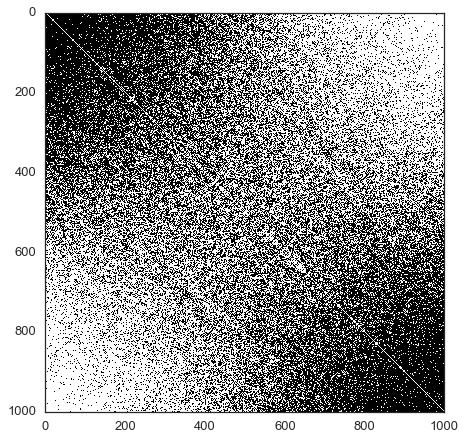

In [96]:
V = 1000
D = 2
N = 5
X = np.column_stack((np.linspace(-2, 2, V), np.zeros((V, D-1))))
true_model = LatentSpaceModel(V, D, X=X, b=0)
As = [true_model.generate() for _ in range(N)]

plt.imshow(As[0], vmin=0, vmax=1, interpolation="nearest")

In [97]:
test_model = LatentSpaceModel(V, D, b=0)
for A in As:
    test_model.add_data(A)

for _ in progprint_xrange(200):
    test_model.resample()


.........................  [  25/200,    0.83sec avg, ETA 02:24 ]
.........................  [  50/200,    0.83sec avg, ETA 02:04 ]
.........................  [  75/200,    0.83sec avg, ETA 01:43 ]
.........................  [ 100/200,    0.83sec avg, ETA 01:23 ]
.........................  [ 125/200,    0.83sec avg, ETA 01:02 ]
.........................  [ 150/200,    0.83sec avg, ETA 41.27 ]
.........................  [ 175/200,    0.82sec avg, ETA 20.62 ]
.........................  [ 200/200,    0.83sec avg, ETA 0.00 ]

   0.83sec avg, 02:45 total



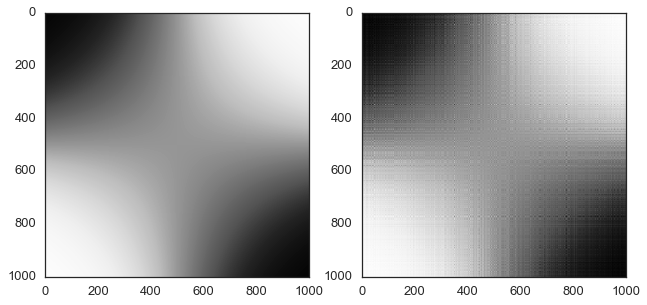

In [98]:
plt.subplot(121)
plt.imshow(true_model.rho(), vmin=0, vmax=1, interpolation="nearest")
plt.subplot(122)
plt.imshow(test_model.rho(), vmin=0, vmax=1, interpolation="nearest")